<a href="https://colab.research.google.com/github/armiro/canine-disease-diagnosis/blob/main/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and data importing

In [ ]:
# update sklearn package to v0.24.x which is the latest version
!pip install --upgrade scikit-learn
# install shap library to draw fancy model explainations
!pip install shap
# install skmultilearn for multi-label classification
!pip install scikit-multilearn
# install dython to plot correlation matrix for nominal/continuous data in same plot
!pip install dython

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [3]:
dataset = pd.read_csv("/content/canine_chemical_dataset_v1.6.csv")
print(dataset.head())

features = dataset.iloc[:, :30]
labels = dataset.iloc[:, 30:]

              Species   Age  ... Volume depletion  hepatocellular injury
0       HERDING GROUP  10.0  ...                0                      0
1  NON-SPORTING GROUP  13.0  ...                0                      0
2       WORKING GROUP   1.0  ...                0                      0
3       HERDING GROUP   6.0  ...                0                      0
4       HERDING GROUP   3.0  ...                0                      0

[5 rows x 244 columns]


## EDA: feature correlation detection

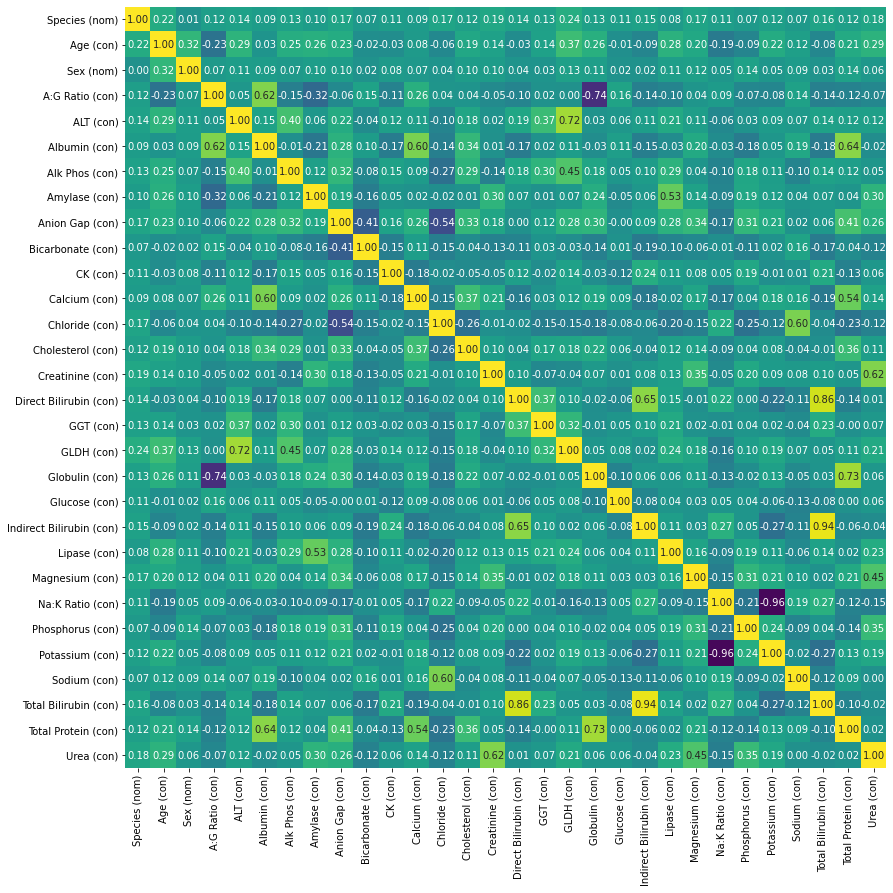

In [ ]:
# plot correlation matrix for both continuous (con) and categorical (nom) features
#  in the same plot. set 'theil u' as True, for asymetrical matrix
from dython.nominal import associations
corr_mat = associations(features, nominal_columns='auto', mark_columns=True, theil_u=True,
                        figsize=(14, 14), fmt='.2f', cbar=False, cmap='viridis')

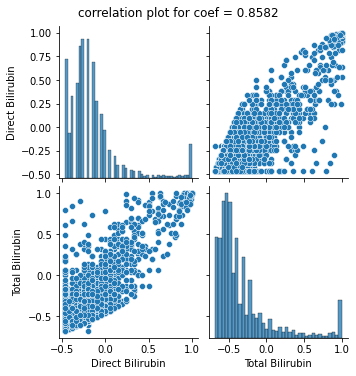

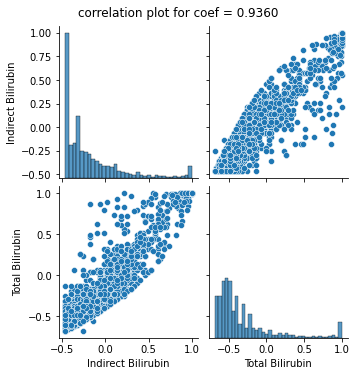

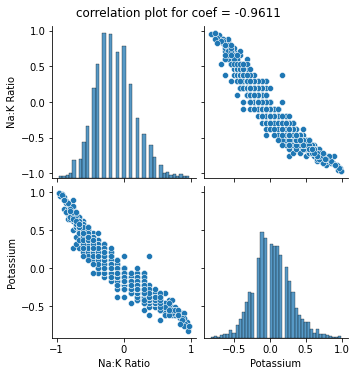

In [ ]:
for r_idx, row in enumerate(corr_mat['corr'].values):
    for c_idx, e in enumerate(row[r_idx+1:]):
        if ((e >= 0.8) | (e <= -0.8)) & (r_idx != c_idx):
            plt.rcParams['figure.figsize'] = (5,5)
            sub_df = features[[features.columns[r_idx], features.columns[c_idx+r_idx+1]]]
            cp = sns.pairplot(sub_df)
            cp.fig.suptitle("correlation plot for coef = %.4f" % e, y=1.03)
            plt.show()

according to the correlation map, we have some features which have high level of correlations. We must perform feature engineering (dim. reduction using PCA or creating new feature based on correlated ones) on some of the input features

## EDA: label correlation detection and reduction strategies

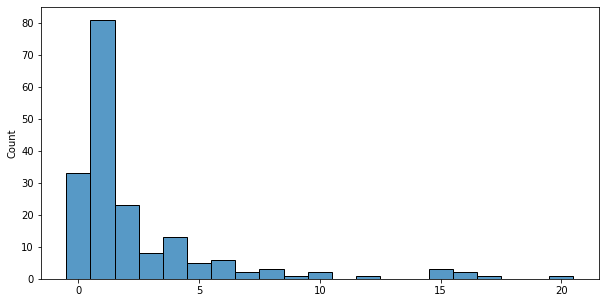

In [ ]:
# one last prep step for labels: we have too many (214) labels which could be shrunken
# to much smaller number of labels. we have to let go of labels with few occurances
label_freqs = list()
label_names = list()
for label, column in labels.iteritems():
    label_names.append(label)
    label_freqs.append(np.sum(column))

fig = plt.figure(figsize=(10, 5))
sns.histplot(label_freqs, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()

which threshold? we can omit labels with freq < 5 (then change later to see differences). on average, each label happens 26.5 times.

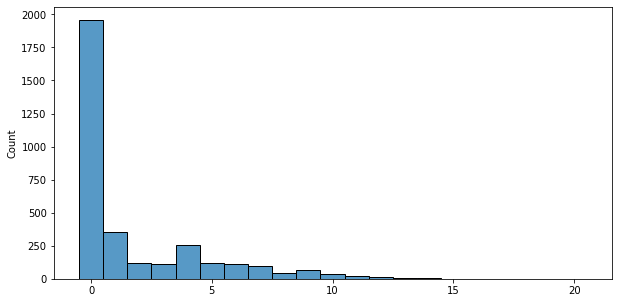

In [ ]:
# having labels that never happen (freq=0) is weird. Let's see how many labels are
# activated for each record
num_activated_labels = list()
for row_idx, row in labels.iterrows():
    num_activated_labels.append(np.sum(row))

fig = plt.figure(figsize=(10, 5))
sns.histplot(num_activated_labels, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()

we can see that many records have no activated labels! on average, each record has 1.78 activated labels. Since records with no activated labels mean the canine breed is healthy, we certainly keep these records.
actually, since we have 1958 healthy records out of 3329 samples, we can do a binary disease detection at first and perform disease classification on unhealthy predictions (hierarchical classification).

**possible model development approaches:**
1. hierarchical classification; define `is_sick` as the superlabel to apply multi-label classification only on those who are sick.
2. flat classification; reduce number of labels from 214 to a reasonable number (ideally < 50), then apply multi-label classification once to classify all disease labels at the same time.
3. binary classification; apply binary classification only on those labels that occur the most (~ 3 labels with most occurances)

## Model development

In [4]:
# construct feature transformation pipeline
ct = ColumnTransformer(
    [('onehot_encoder', OneHotEncoder(drop='first', sparse=False), [0, 2]),
     ('minmax_scaler', MinMaxScaler((0, 1)), [1])], # scale 'age' to [0,1]
    remainder='passthrough') # leave other columns untouched
features_encoded = ct.fit_transform(X=features)

### Hierarchical classification: `is_sick` as the superlabel

In [ ]:
# create new label: sick or not? (for binary classification)
is_sick = np.array([1.0 if np.sum(row) >= 1 else 0.0 for row in labels.values])
print('num pos values:', np.sum(is_sick))
print('num neg values:', len(is_sick) - np.sum(is_sick))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(is_sick), 
                                                  y=is_sick)
class_weights = dict({0: class_weights[0], 1: class_weights[1]})
pos_ratio = np.sum(is_sick) / (len(is_sick)-np.sum(is_sick))

num pos values: 1371.0
num neg values: 1958.0


In [ ]:
# # feature engineering: avg value of blood-tests (values within normal ranges are set to 0)
# features_encoded[:,11:] = np.array([np.where(e<0, np.abs(e), e) for e in features_encoded[:,11:]])
# avg_val = np.array([np.sum(e)/28 for e in features_encoded[:, 11:]]).reshape(-1, 1)

# # feature engineering: avg number of zeros (values within normal ranges are set to 0)
# avg_zeros = np.array([(e.size - np.count_nonzero(e))/28 for e in features_encoded[:, 11:]]).reshape(-1, 1)

In [ ]:
# perform K-Fold cross-validation and find model scores on training/validation data
def get_results_of(model):
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
    results = cross_validate(estimator=model, X=features_encoded, y=is_sick, cv=cv, 
                             scoring=['accuracy', 'roc_auc'])
    acc_scores = results['test_accuracy']
    print('mean ACC is %.3f (std=%.3f) / best ACC is %.3f' 
            % (abs(np.mean(acc_scores)), np.std(acc_scores), abs(np.max(acc_scores))))
    auc_scores = results['test_roc_auc']
    print('mean ROC AUC is %.3f (std=%.3f) / best ROC AUC is %.3f' 
            % (abs(np.mean(auc_scores)), np.std(auc_scores), abs(np.max(auc_scores))))

In [ ]:
from sklearn.svm import SVC
params = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': [0.1, 1, 10], 
          'degree': [1, 2, 3, 4]}
base_clf = SVC(class_weight=class_weights)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for SVM Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.tree import DecisionTreeClassifier
params = {'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']}
base_clf = DecisionTreeClassifier(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for DecisionTree Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.linear_model import LogisticRegression
params = {'C': [0.1, 1.0, 2.0, 10.0], 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
base_clf = LogisticRegression(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for LogReg Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.ensemble import RandomForestClassifier
params = {'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy'],
          'n_estimators': [20, 50, 100, 200]}
base_clf = RandomForestClassifier(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for RF Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


import xgboost as xgb
params = {'max_depth': [2, 3, 4, 5], 'n_estimators': [20, 50, 100, 200]}
base_clf = xgb.XGBClassifier(scale_pos_weight=1/pos_ratio)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for XGB Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)

best observed parameters for SVM Clf: {'C': 0.1, 'degree': 4, 'kernel': 'poly'}
mean cross-validation ACC is 0.599 (std=0.015) / best cross-validation ACC is 0.637
mean cross-validation ROC AUC is 0.601 (std=0.025) / best cross-validation ROC AUC is 0.653
-----------------------------------------------------
best observed parameters for DecisionTree Clf: {'criterion': 'gini', 'max_depth': 2}
mean cross-validation ACC is 0.593 (std=0.020) / best cross-validation ACC is 0.622
mean cross-validation ROC AUC is 0.616 (std=0.024) / best cross-validation ROC AUC is 0.645
-----------------------------------------------------
best observed parameters for LogReg Clf: {'C': 0.1, 'solver': 'newton-cg'}
mean cross-validation ACC is 0.589 (std=0.020) / best cross-validation ACC is 0.625
mean cross-validation ROC AUC is 0.614 (std=0.025) / best cross-validation ROC AUC is 0.651
-----------------------------------------------------
best observed parameters for RF Clf: {'criterion': 'gini', 'max_depth'

best model in terms of average ACC as well as AUC is (as expected) the **XGBoost classifier**.
Best achieved mean ACC is **~60%** which is not acceptable. Hence, hierarchical classification with this superlabel is NOT possible.

### Flat multi-label classification: classify reduced number of labels

In [ ]:
drop_list = list()
for label, column in labels.iteritems():
    if np.sum(column) < 5: # omit labels with less than 5 occurances
        drop_list.append(label)

reduced_labels = labels.drop(columns=drop_list)
temp_num_labels = len(reduced_labels.values[0])
print('number of labels is reduced from %d to %d' % (len(label_names), temp_num_labels))

number of labels is reduced from 214 to 56


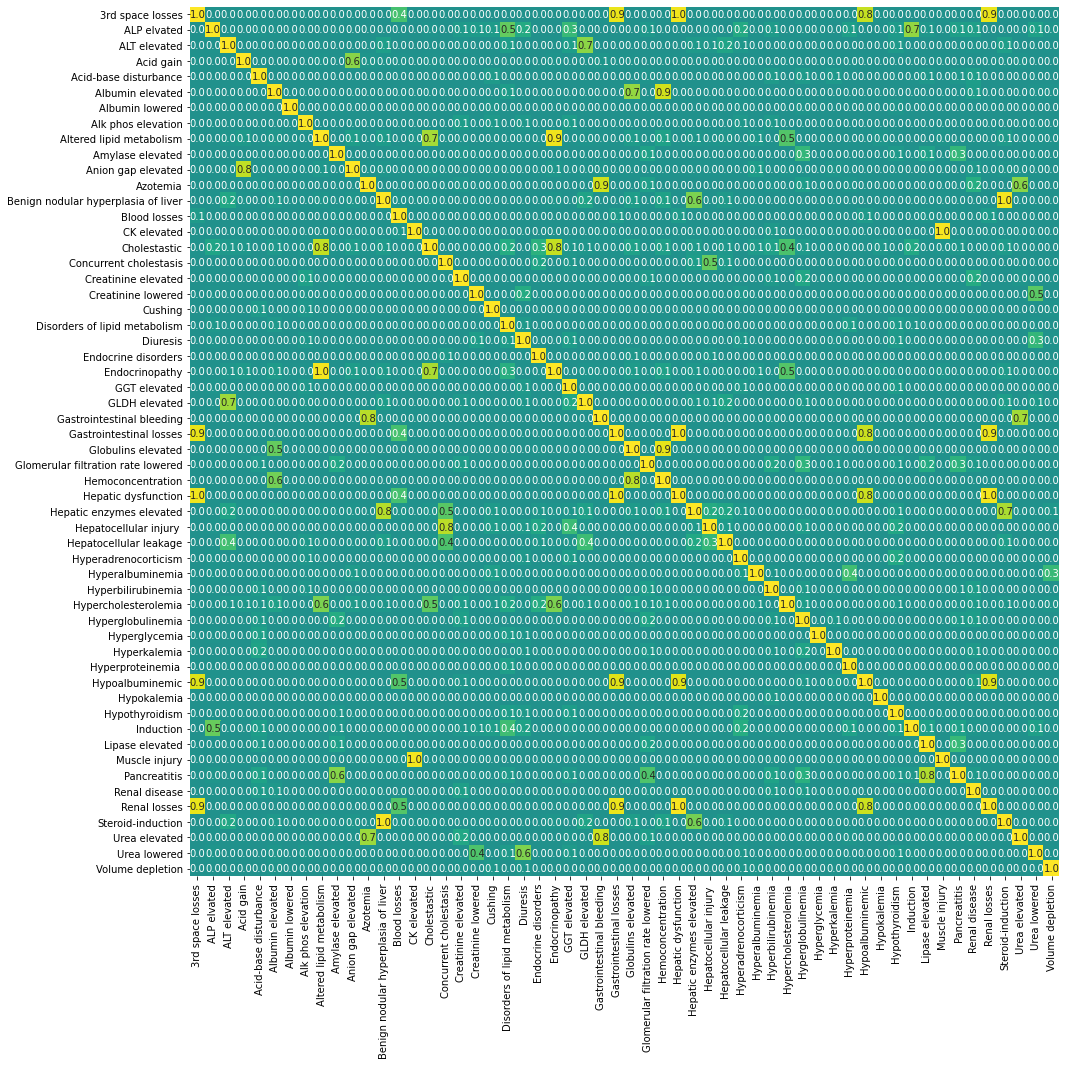

In [ ]:
# plot correlation matrix between labels. all labels are considered as categorical
# set 'theil u' as True, since we want to reduce labels as much as possible.
from dython.nominal import associations
corr_mat = associations(reduced_labels, nominal_columns='all', theil_u=True, figsize=(16, 16), 
                        fmt='.1f', cbar=False, cmap='viridis')

In [ ]:
columns_to_drop = list()
for r_idx, row in enumerate(corr_mat['corr'].values):
    for c_idx, e in enumerate(row[r_idx+1:]):
        if (e > 0.7) & (r_idx != c_idx):
            plt.rcParams['figure.figsize'] = (5,5)
            print('confusion matrix between %s and %s' % (reduced_labels.columns[r_idx], 
                                                          reduced_labels.columns[c_idx+r_idx+1]))
            print(sklearn.metrics.confusion_matrix(reduced_labels[reduced_labels.columns[r_idx]], 
                                                   reduced_labels[reduced_labels.columns[c_idx+r_idx+1]]))
            print('f1-score:')
            print(sklearn.metrics.f1_score(reduced_labels[reduced_labels.columns[r_idx]], 
                                           reduced_labels[reduced_labels.columns[c_idx+r_idx+1]]))
            print('proceed further? (y/n)')
            if input() == 'y':
                columns_to_drop.append(reduced_labels.columns[c_idx+r_idx+1])
                print('added %s to drop list' % reduced_labels.columns[c_idx+r_idx+1])
            else:
                print('label reduction aborted for this label.')
                pass
            print('--------------------------------------------')

confusion matrix between 3rd space losses and Gastrointestinal losses
[[3217    3]
 [   2  107]]
f1-score:
0.9771689497716896
proceed further? (y/n)
y
added Gastrointestinal losses to drop list
--------------------------------------------
confusion matrix between 3rd space losses and Hepatic dysfunction
[[3219    1]
 [   2  107]]
f1-score:
0.9861751152073732
proceed further? (y/n)
y
added Hepatic dysfunction to drop list
--------------------------------------------
confusion matrix between 3rd space losses and Hypoalbuminemic
[[3207   13]
 [   1  108]]
f1-score:
0.9391304347826087
proceed further? (y/n)
n
label reduction aborted for this label.
--------------------------------------------
confusion matrix between 3rd space losses and Renal losses
[[3217    3]
 [   2  107]]
f1-score:
0.9771689497716896
proceed further? (y/n)
y
added Renal losses to drop list
--------------------------------------------
confusion matrix between Albumin elevated and Hemoconcentration
[[3321    0]
 [   3  

In [ ]:
reduced_labels = reduced_labels.drop(columns=np.unique(columns_to_drop))
print('these labels are dropped:', np.unique(columns_to_drop))
print('number of labels is reduced from %d to %d' % (temp_num_labels, len(reduced_labels.values[0])))

these labels are dropped: ['Endocrinopathy' 'Gastrointestinal losses' 'Hepatic dysfunction'
 'Muscle injury' 'Renal losses' 'Steroid-induction']
number of labels is reduced from 56 to 50


In [ ]:
# define multilabel classification metrics
def micro_avg_f1_score(y, yhat):
    return sklearn.metrics.f1_score(y, yhat, average='micro')

def alpha_evaluation_score(y, yhat):
    alpha = 1.0; beta = 1.0; gamma = 0.8 # FN is more important than FP, so beta > gamma
    # compute true positives across training examples and labels
    tp = np.sum(np.logical_and(y, yhat))
    # compute false negatives (Missed Labels) across training examples and labels
    fn = np.sum(np.logical_and(y, np.logical_not(yhat)))
    # compute False Positive across training examples and labels.
    fp = np.sum(np.logical_and(np.logical_not(y), yhat))
    # Compute alpha evaluation score
    alpha_score = (1 - ((beta*fn + gamma*fp) / (tp + fn + fp + 0.00001)))**alpha
    return alpha_score


metrics = {'micro_f1': sklearn.metrics.make_scorer(micro_avg_f1_score),
           'alpha_eval': sklearn.metrics.make_scorer(alpha_evaluation_score)}

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(features_encoded, reduced_labels.values, 
                                                    test_size=0.1, random_state=0)

model = DecisionTreeClassifier(class_weight='balanced', random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print('micro F1:', micro_avg_f1_score(y=y_test, yhat=preds))
print('alpha eval:', alpha_evaluation_score(y=y_test, yhat=preds))

f = list()
a = list()
for idx, col_name in enumerate(reduced_labels.columns):
    # print('classifying %s label:' % col_name)
    model.fit(X_train, y_train[:, idx:idx+1]) # if needed: idx:idx+1
    preds = model.predict(X_test)
    # print('alpha:', alpha_evaluation_score(y=y_test[:, idx], yhat=preds))
    # print('f1:', micro_avg_f1_score(y=y_test[:, idx], yhat=preds))
    a.append(alpha_evaluation_score(y=y_test[:, idx], yhat=preds))
    f.append(micro_avg_f1_score(y=y_test[:, idx], yhat=preds))

print('mean per-class micro F1:', np.mean(f))
print('mean per-class alpha eval:', np.mean(a))

micro F1: 0.17614678899082567
alpha eval: 0.19939638632398005
mean per-class micro F1: 0.9582582582582582
mean per-class alpha eval: 0.2747847539794856


In [ ]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

model = ClassifierChain(DecisionTreeClassifier(class_weight='balanced', random_state=0))
model.fit(X_train, y_train)
preds = model.predict(X_test).toarray()

print('micro F1:', micro_avg_f1_score(y=y_test, yhat=preds))
print('alpha eval:', alpha_evaluation_score(y=y_test, yhat=preds))

f = list()
a = list()
for idx, col_name in enumerate(reduced_labels.columns):
    # print('classifying %s label:' % col_name)
    model.fit(X_train, y_train[:, idx:idx+1]) # if needed: idx:idx+1
    preds = model.predict(X_test).toarray()
    # print('alpha:', alpha_evaluation_score(y=y_test[:, idx], yhat=preds))
    # print('f1:', micro_avg_f1_score(y=y_test[:, idx], yhat=preds))
    a.append(alpha_evaluation_score(y=y_test[:, idx], yhat=preds))
    f.append(micro_avg_f1_score(y=y_test[:, idx], yhat=preds))

print('mean per-class micro F1:', np.mean(f))
print('mean per-class alpha eval:', np.mean(a))

micro F1: 0.25415676959619954
alpha eval: 0.2141496705557867


In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# matrices = multilabel_confusion_matrix(y_test, preds)
# for mx in matrices:
#     ConfusionMatrixDisplay(mx).plot()

### Binary classification: most occurring labels

In [5]:
label_freqs = list()
for label, column in labels.iteritems():
    label_freqs.append(np.sum(column))

target_diseases = list()
for idx, freq in enumerate(label_freqs):
    if freq > 150: # find labels with >150 occurrances
        print('The label "%s" has %d occurrances' % (labels.columns[idx], freq))
        if freq > 150: # get labels with >150 occurrances as target
            target_diseases.append((labels.columns[idx], labels[labels.columns[idx]].values))
            print('Added to the list of target diseases')

The label "Acid gain" has 153 occurrances
Added to the list of target diseases
The label "Altered lipid metabolism" has 498 occurrances
Added to the list of target diseases
The label "Anion gap elevated" has 208 occurrances
Added to the list of target diseases
The label "Benign nodular hyperplasia of liver" has 182 occurrances
Added to the list of target diseases
The label "Cholestastic" has 594 occurrances
Added to the list of target diseases
The label "Endocrinopathy" has 509 occurrances
Added to the list of target diseases
The label "Hepatic enzymes elevated" has 259 occurrances
Added to the list of target diseases
The label "Hepatocellular leakage" has 322 occurrances
Added to the list of target diseases
The label "Hyperalbuminemia" has 173 occurrances
Added to the list of target diseases
The label "Hypercholesterolemia" has 824 occurrances
Added to the list of target diseases
The label "Steroid-induction" has 185 occurrances
Added to the list of target diseases


In [6]:
target_diseases

[('Acid gain', array([1, 0, 0, ..., 0, 1, 0])),
 ('Altered lipid metabolism', array([1, 1, 0, ..., 0, 1, 0])),
 ('Anion gap elevated', array([1, 0, 0, ..., 0, 1, 0])),
 ('Benign nodular hyperplasia of liver', array([1, 1, 0, ..., 0, 1, 0])),
 ('Cholestastic', array([1, 1, 0, ..., 0, 1, 0])),
 ('Endocrinopathy', array([1, 1, 0, ..., 0, 1, 0])),
 ('Hepatic enzymes elevated', array([1, 1, 0, ..., 0, 1, 0])),
 ('Hepatocellular leakage', array([1, 0, 1, ..., 0, 0, 0])),
 ('Hyperalbuminemia', array([0, 0, 0, ..., 0, 0, 0])),
 ('Hypercholesterolemia', array([1, 1, 1, ..., 0, 1, 0])),
 ('Steroid-induction', array([1, 1, 0, ..., 0, 1, 0]))]

In [111]:
disease_idx = 10
target_disease = target_diseases[disease_idx][1]
print('train/test for "%s" as the label' % target_diseases[disease_idx][0])

train/test for "Steroid-induction" as the label


In [112]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(target_disease), 
                                                  y=target_disease)
class_weights = dict({0: class_weights[0], 1: class_weights[1]})
print('class weights:', class_weights)
pos_ratio = np.sum(target_disease) / (len(target_disease)-np.sum(target_disease))
print('positive ratio:', pos_ratio)

class weights: {0: 0.5294211195928753, 1: 8.997297297297298}
positive ratio: 0.058842239185750635


In [113]:
# perform K-Fold cross-validation and find model scores on training/validation data
def get_results_of(model, data, target):
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    results = cross_validate(estimator=model, X=data, y=target, cv=cv, 
                             scoring=['f1', 'roc_auc'])
    f1_scores = results['test_f1']
    print('mean F1 is %.3f (std=%.3f) / best F1 is %.3f' 
            % (abs(np.mean(f1_scores)), np.std(f1_scores), abs(np.max(f1_scores))))
    auc_scores = results['test_roc_auc']
    print('mean ROC AUC is %.3f (std=%.3f) / best ROC AUC is %.3f' 
            % (abs(np.mean(auc_scores)), np.std(auc_scores), abs(np.max(auc_scores))))

In [114]:
import xgboost as xgb
params = {'max_depth': [3, 5, 7, 9], 'n_estimators': [50, 100, 300, 500]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
base_clf = xgb.XGBClassifier(scale_pos_weight=1/pos_ratio)

clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv, scoring='accuracy')
clfs.fit(features_encoded, target_disease)
print('best observed parameters for this model:', clfs.best_params_)

best observed parameters for this model: {'max_depth': 7, 'n_estimators': 500}


In [115]:
model = clfs.best_estimator_
get_results_of(model=model, data=features_encoded, target=target_disease)

mean F1 is 0.075 (std=0.061) / best F1 is 0.167
mean ROC AUC is 0.827 (std=0.015) / best ROC AUC is 0.849


In [116]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='/content/best_weights.hdf5',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cb_list = [checkpoint]


def MLP(input_shape):
    a0 = Input(shape=input_shape)
    a1 = Dense(units=100, activation='relu')(a0)
    # a2 = Dense(units=50, activation='relu')(a1)
    a3 = Dense(units=1, activation='sigmoid')(a1)
    return Model(inputs=a0, outputs=a3, name='binary_mlp')


model = MLP(input_shape=features_encoded[0].shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target_disease, 
                                                    test_size=0.2, random_state=21)


training = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),
                     class_weight=class_weights, callbacks=cb_list)

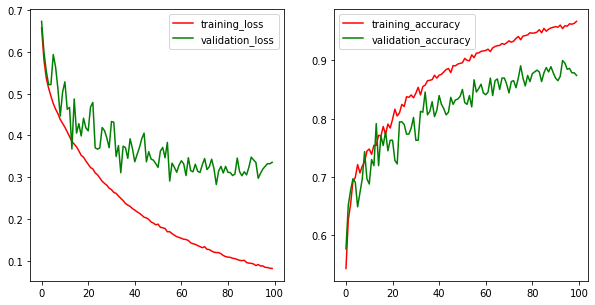

In [118]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training.history['loss'], color='r', label='training_loss')
plt.plot(training.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(training.history['accuracy'], color='r', label='training_accuracy')
plt.plot(training.history['val_accuracy'], color='g', label='validation_accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

model.load_weights('/content/best_weights.hdf5')
# model = xgb.XGBClassifier(scale_pos_weight=1/pos_ratio, max_depth=5, n_estimators=300)
# model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('number of test-set images:', len(y_test))
print(y_test)
y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)), decimals=2)[0]
print(y_pred)
y_pred_rnd = np.round(np.reshape(a=y_pred, newshape=(1, -1)))[0]
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_rnd)
print('confusion matrix:')
print(cm)
print('test-set accuracy:', (cm[0][0] + cm[1][1])/np.sum(cm))

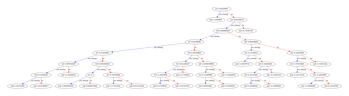

In [ ]:
xgb.plot_tree(booster=clfs.best_estimator_, num_trees=0)
plt.rcParams['figure.figsize'] = [12, 6]
plt.show()

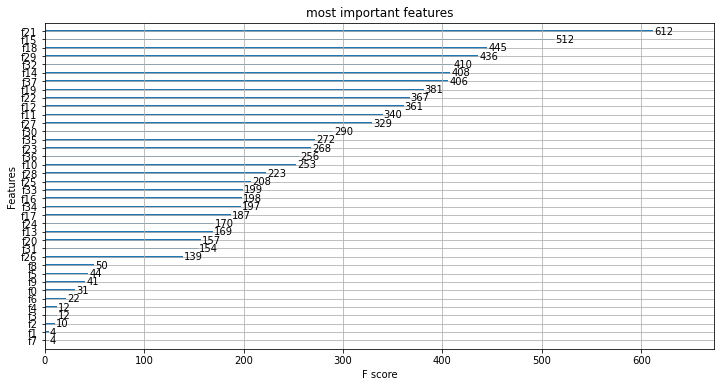

In [ ]:
xgb.plot_importance(booster=clfs.best_estimator_)
plt.rcParams['figure.figsize'] = [12, 6]
plt.title('most important features')
plt.show()

In [ ]:
column_names = list(ct.named_transformers_['onehot_encoder'].get_feature_names())
column_names.extend(['age'])
column_names.extend(features.columns[3:])
features_encoded_with_labels = pd.DataFrame(features_encoded, columns=column_names)

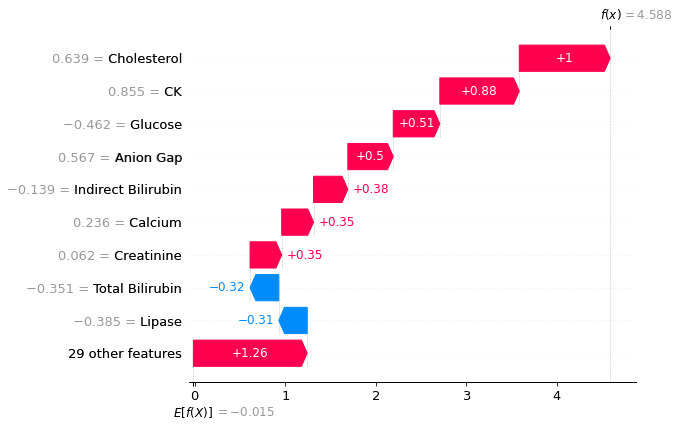

In [ ]:
import shap
explainer = shap.Explainer(model=model)
shap_values = explainer(X=features_encoded_with_labels, y=target_disease)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

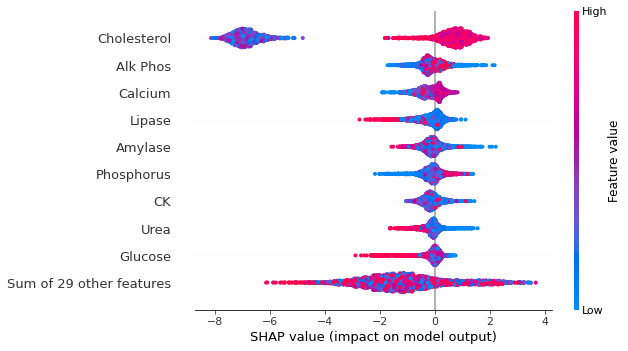

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

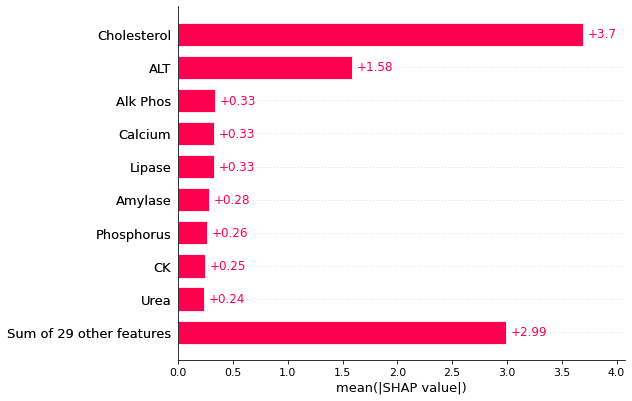

In [ ]:
shap.plots.bar(shap_values)